In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "\\datasets\\covenant_copy_smb_CreateRequest_2020-09-22145302.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [20]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess_labelEncoder(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    le = preprocessing.LabelEncoder()
    
    for column in df.columns:            
#         # if dtype is int, does not need to convert to string , e.g. EventID
#         if isinstance(df[column][0], int) and df[column][0] != 0:
#             le.fit(df[column])
#             df[column] = le.transform(df[column])
            
        # convert to list of strings and use label encoder to label
#         else:
        df[column] = list(map(str, df[column]))
        le.fit(df[column])
        df[column] = le.transform(df[column])
            
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data
    

In [3]:
# for debugging only
count_nan(df)
count_nan(new_data)

Keywords 0
SeverityValue 0
TargetObject 185
EventTypeOrignal 185
EventID 0
ProviderGuid 0
ExecutionProcessID 0
host 0
Channel 0
UserID 94
AccountType 94
ThreadID 0
ProcessGuid 173
Details 430
EventReceivedTime 0
Opcode 0
EventTime 0
@timestamp 0
SourceModuleType 0
port 0
AccountName 94
RecordNumber 0
Task 0
Domain 94
@version 0
OpcodeValue 0
SourceModuleName 0
Severity 0
SourceName 0
Version 0
Image 173
Category 0
UtcTime 94
Hostname 0
RuleName 94
tags 0
Application 429
ProcessId 424
EventType 321
Message 413
FilterRTID 429
LayerRTID 429
Protocol 426
SourcePort 426
LayerName 429
SourceAddress 429
RemoteUserID 478
Direction 478
DestPort 478
DestAddress 478
RemoteMachineID 478
SubjectDomainName 492
SubjectUserSid 492
SubjectLogonId 492
ProcessName 501
SubjectUserName 492
Status 502
SourceImage 427
SourceProcessGUID 427
TargetImage 427
GrantedAccess 427
SourceProcessId 427
SourceThreadId 427
TargetProcessGUID 427
TargetProcessId 427
CallTrace 427
TargetFilename 501
CreationUtcTime 501
Act

NameError: name 'new_data' is not defined

In [4]:
df = df[["Channel", "EventID", "ShareName", "SubjectUserName", "SubjectLogonId", "AccessMask", "Image", "RelativeTargetName", "TargetFilename"]]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.head()

,Channel,EventID,ShareName,SubjectUserName,SubjectLogonId,AccessMask,Image,RelativeTargetName,TargetFilename
0,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,C:\windows\Explorer.EXE,NaN,NaN
1,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,C:\windows\Explorer.EXE,NaN,NaN
2,security,5158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,security,5156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Security,5158,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

In [5]:
X = df
y = labelList(X.shape[0], [58, 57, 61, 211])

# replicate positive data 50 times
# X, y = pd_replicate(X, y, [61, 211], 50)
X.shape

(506, 9)

## Use CTGAN to generate new data

In [29]:
from sdv.demo import load_tabular_demo

# data = load_tabular_demo(df)
# print(df.iloc[0])

In [6]:
from sdv.tabular import CTGAN

model = CTGAN()
model.fit(X)

In [27]:
# save and reuse the model
model.save('RemoteCreateFileSMB.pkl')

# loaded = CTGAN.load('RemoteCreateFileSMB.pkl')
# new_data = loaded.sample(num_rows=100)

In [7]:
new_data = model.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,ShareName,SubjectUserName,SubjectLogonId,AccessMask,Image,RelativeTargetName,TargetFilename
0,Security,12,NaN,NaN,NaN,NaN,C:\windows\System32\svchost.exe,NaN,NaN
1,Microsoft-Windows-Sysmon/Operational,5158,NaN,-,NaN,NaN,NaN,NaN,NaN
2,Microsoft-Windows-Sysmon/Operational,4689,\\*\C$,NaN,NaN,NaN,NaN,NaN,NaN
3,Security,4689,NaN,NaN,0x4e13b2e,NaN,C:\windows\system32\lsass.exe,NaN,NaN
4,Security,4634,NaN,NaN,NaN,NaN,C:\windows\system32\lsass.exe,NaN,NaN


In [8]:
# for debugging only
count_items(preprocess_labelEncoder(df))
count_items(preprocess_labelEncoder(new_data))

Channel :  [(0, 412), (1, 44), (2, 50)]
EventID :  [(0, 79), (1, 5), (2, 245), (3, 76), (4, 3), (5, 2), (6, 2), (7, 2), (8, 2), (9, 3), (10, 1), (11, 3), (12, 2), (13, 3), (14, 28), (15, 49), (16, 1)]
ShareName :  [(0, 501), (1, 4), (2, 1)]
SubjectUserName :  [(0, 4), (1, 492), (2, 1), (3, 2), (4, 1), (5, 6)]
SubjectLogonId :  [(0, 492), (1, 4), (2, 3), (3, 6), (4, 1)]
AccessMask :  [(0, 501), (1, 2), (2, 1), (3, 1), (4, 1)]
Image :  [(0, 173), (1, 2), (2, 11), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 10), (9, 147), (10, 1), (11, 150), (12, 1), (13, 6)]
RelativeTargetName :  [(0, 503), (1, 1), (2, 2)]
TargetFilename :  [(0, 501), (1, 1), (2, 1), (3, 2), (4, 1)]
Channel :  [(0, 627235), (1, 112017), (2, 260748)]
EventID :  [(0, 91095), (1, 47892), (2, 329257), (3, 104845), (4, 11852), (5, 21450), (6, 19130), (7, 7673), (8, 25399), (9, 36003), (10, 4944), (11, 13537), (12, 50168), (13, 86220), (14, 59053), (15, 86391), (16, 5091)]
ShareName :  [(0, 872845), (1, 98494), (2, 28661)]
Sub

0

## Use hunter program on new data

In [9]:
# Analytic I
I = (
# df[['@timestamp','Hostname','ShareName','SubjectUserName','SubjectLogonId','AccessMask']]
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]


[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140") # EventID are changed to strings
    & (~new_data['ShareName'].str.contains('.*IPC.*', regex=True, na=True))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)
I

,ShareName,SubjectUserName,SubjectLogonId,AccessMask
218,\\*\C$,NaN,NaN,NaN
1283,\\*\C$,NaN,NaN,NaN
4003,\\*\C$,NaN,0x0,NaN
4280,\\*\C$,NaN,0x4e13b2e,NaN
4668,\\*\C$,NaN,NaN,NaN
...,...,...,...,...
997761,\\*\C$,NaN,0x3e7,NaN
997900,\\*\C$,NaN,0x4e13b2e,NaN
998326,\\*\C$,NaN,NaN,NaN
999551,\\*\C$,NaN,NaN,0x17019f


In [10]:
# IPCShareDf
Counter(I['SubjectLogonId']).items()

dict_items([(nan, 1511), ('0x0', 73), ('0x4e13b2e', 247), ('0x7b90596', 43), ('0x3e7', 100)])

In [11]:
# Analytic II
IPCShareDf = (
# 
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.contains('.*IPC.*', regex=True))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
    & (new_data['SubjectLogonId']) # SubjectLogonId cannot be NaN when merging
]
)

CShareDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)

# (
# pd.merge(IPCShareDf, CShareDf,
#     on = 'SubjectLogonId', how = 'inner')
# )

II = (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
    & (
        (new_data['SubjectLogonId'] == '0x4e13b2e')
        | (new_data['SubjectLogonId'] == '0x0')
        | (new_data['SubjectLogonId'] == '0x7b90596')
        | (new_data['SubjectLogonId'] =='0x3e7')
    )
]
)
II

,ShareName,SubjectUserName,SubjectLogonId,AccessMask
4003,\\*\C$,NaN,0x0,NaN
4280,\\*\C$,NaN,0x4e13b2e,NaN
6801,\\*\C$,NaN,0x7b90596,NaN
13966,\\*\C$,-,0x4e13b2e,NaN
16353,\\*\C$,pgustavo,0x4e13b2e,0x1
...,...,...,...,...
990880,\\*\C$,NaN,0x3e7,NaN
993576,\\*\C$,-,0x3e7,0x17019f
994975,\\*\C$,NaN,0x3e7,NaN
997761,\\*\C$,NaN,0x3e7,NaN


In [12]:
Counter(II['SubjectLogonId']).items()

dict_items([('0x0', 73), ('0x4e13b2e', 247), ('0x7b90596', 43), ('0x3e7', 100)])

In [13]:
# Analytic III
III = (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)
III

,ShareName,SubjectUserName,SubjectLogonId,RelativeTargetName
17299,\\*\C$,pgustavo,NaN,NaN
35293,\\*\C$,pgustavo,NaN,NaN
37408,\\*\C$,NaN,NaN,NaN
46432,\\*\C$,NaN,NaN,NaN
52389,\\*\C$,NaN,NaN,NaN
...,...,...,...,...
877408,\\*\C$,NaN,0x4e13b2e,NaN
901137,\\*\C$,pgustavo,0x0,NaN
912823,\\*\C$,NaN,0x0,ProgramData\GruntHTTP.exe
963122,\\*\C$,NaN,0x0,NaN


In [14]:
# Analytic IV
IPCShareDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.contains('.*IPC.*', regex=True))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)

CShareDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
]
)


firstJoinDf = (
pd.merge(IPCShareDf, CShareDf,
    on = 'SubjectLogonId', how = 'inner')
)

fileAccessedDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
]
)

# (
# pd.merge(firstJoinDf, fileAccessedDf,
#     on = 'SubjectLogonId', how = 'inner')
# )

IV = (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask', 'RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
#     & (~new_data['SubjectUserName'].str.endswith('$', na=False))
    & (
        (new_data['SubjectLogonId'] == '0x4e13b2e')
        | (new_data['SubjectLogonId'] == '0x0')
        | (new_data['SubjectLogonId'] == '0x7b90596')
        | (new_data['SubjectLogonId'] =='0x3e7')
    )
]
)
IV

,ShareName,SubjectUserName,SubjectLogonId,AccessMask,RelativeTargetName
151,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
2351,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
2758,\\*\C$,NaN,0x4e13b2e,NaN,ProgramData\GruntHTTP.exe
3104,\\*\C$,NaN,0x3e7,NaN,NaN
4766,\\*\C$,NaN,0x4e13b2e,NaN,NaN
...,...,...,...,...,...
995181,\\*\C$,pgustavo,0x0,NaN,NaN
996349,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
996861,\\*\C$,pgustavo,0x3e7,NaN,NaN
997103,\\*\C$,WORKSTATION6$,0x4e13b2e,NaN,NaN


In [15]:
# Analytic V
fileAccessedDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
]
)

fileAccessedDf['Filename'] = fileAccessedDf['RelativeTargetName'].str.split('\\').str[-1]

print(Counter(fileAccessedDf['Filename']).items())
# out: dict_items([('GruntHTTP.exe', 55), (nan, 775), ('ProgramData', 39)])

fileCreateDf = (
# (
new_data[['Image','TargetFilename']]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == "11")
    & (new_data['Image'].str.lower() == 'system')
]
)

fileCreateDf['Filename'] = fileCreateDf['TargetFilename'].str.split('\\').str[-1]

# (
# pd.merge(fileAccessedDf, fileCreateDf,
#     on = 'Filename', how = 'inner')
# )

V = (
fileCreateDf[['Image','TargetFilename']]

[(
    (fileCreateDf['Filename'] == 'GruntHTTP.exe')
    | (fileCreateDf['Filename'] == 'ProgramData')
)
]
)
V

dict_items([(nan, 772), ('ProgramData', 31), ('GruntHTTP.exe', 58)])


,Image,TargetFilename
106246,System,C:\ProgramData\GruntHTTP.exe
255787,System,C:\ProgramData\GruntHTTP.exe
421845,System,C:\ProgramData\GruntHTTP.exe
465812,System,C:\ProgramData\GruntHTTP.exe
473890,System,C:\ProgramData\GruntHTTP.exe
529915,System,C:\ProgramData\GruntHTTP.exe
606241,System,C:\ProgramData\GruntHTTP.exe
626441,System,C:\ProgramData\GruntHTTP.exe
692083,System,C:\ProgramData\GruntHTTP.exe


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [24]:
# randomly pick from results of analytics
results = [I, II, III, IV, V]
pick_nums = [9, 9, 9, 9, 9]
gen_data = random_generator(results, pick_nums)

# gen_data = new_data.iloc[[43318, 202587, 344456, 432371, 610375]]
gen_data.shape

(45, 7)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.75


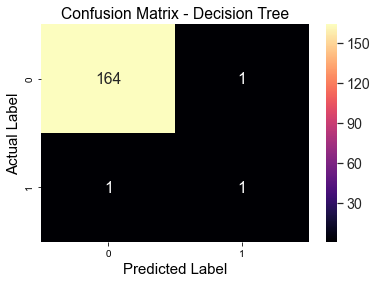

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       165
           1       0.50      0.50      0.50         2

    accuracy                           0.99       167
   macro avg       0.75      0.75      0.75       167
weighted avg       0.99      0.99      0.99       167



In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess_labelEncoder(df)
y = labelList(df.shape[0], [58, 57, 61, 211])
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Original data with generated data

Balanced accuracy score: 0.98


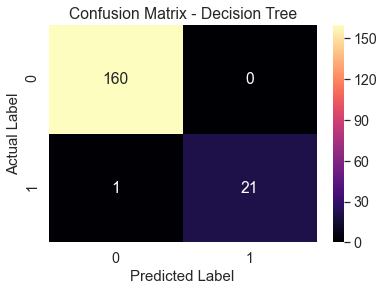

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       160
           1       1.00      0.95      0.98        22

    accuracy                           0.99       182
   macro avg       1.00      0.98      0.99       182
weighted avg       0.99      0.99      0.99       182



In [26]:
# add generated data to the original dataset
df_new = pd.concat([df, gen_data], axis=0)

X = preprocess_labelEncoder(df_new)
y = labelList(df.shape[0], [58, 57, 61, 211])
# generated data are all positive
for i in range(len(gen_data)):
    y.append(1)

clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

## Save generated data

In [32]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + r'\generated_datasets' + r'\covenant_copy_smb_CreateRequest_new.json', orient='records')

dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\covenant_copy_smb_CreateRequest_new.json")
dataset.head()

,ShareName,SubjectUserName,SubjectLogonId,AccessMask,RelativeTargetName,Image,TargetFilename
0,\\*\C$,None,None,0x1,None,None,None
1,\\*\C$,pgustavo,0x4e13b2e,None,None,None,None
2,\\*\C$,None,None,None,None,None,None
3,\\*\C$,pgustavo,None,0x2,None,None,None
4,\\*\C$,None,None,0x1,None,None,None
